In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
#import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [8]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

In [54]:
plt.style.use("seaborn-talk")
plt.rcParams['image.cmap'] = 'viridis'

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [10]:
nside = 2048
lmax = 2048

In [6]:
comp = "IQU"

In [7]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [8]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb = False

In [7]:
datadir=Path("/global/cscratch1/sd/jianyao/Dust")

# Setting the inputs 

# Setting the inputs 
## Dust maps 
- We use the  2015 GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with 21.8' resolution https://www.dropbox.com/s/hicocet83z31ob3/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits?dl=0

- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with 80' reso.  



In [20]:
dust_varresI = datadir / "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"
dust_varresP = datadir / "COM_CompMap_IQU-thermaldust-gnilc-varres_2048_R3.00.fits"

Transform maps to double precision for computations

In [36]:
m_planck_varres, h1 = hp.read_map(dust_varresP, [c + "_STOKES" for c in comp], dtype=np.float64, h=True) # K_CMB
I_planck_varres, h2 = hp.read_map(dust_varresI, dtype=np.float64, h=True) # MJy/sr

In [38]:
m_planck_varres <<= u.K_CMB
I_planck_varres <<= u.MJy / u.sr
m_planck_varres = m_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

then we are ready to combine both maps into one single TQU map. 

In [39]:
m_planck_varres[0] = I_planck_varres
del I_planck_varres

In [40]:
m_planck_varres.dtype

dtype('float64')

### GAL080 Planck  mask 

we mask the galaxy to estimate the power spectra with Namaster before and after small scale injection. 


In [41]:
planck_mask_filename = datadir / "HFI_Mask_GalPlane-apo2_2048_R2.00.fits"

In [43]:
planck_mask = hp.read_map(planck_mask_filename, ["GAL080"])

planck_mask = np.int_(np.ma.masked_not_equal(planck_mask, 0.0).mask)
fsky = planck_mask.sum() / planck_mask.size

masking 0.7912631829579672 of the sky


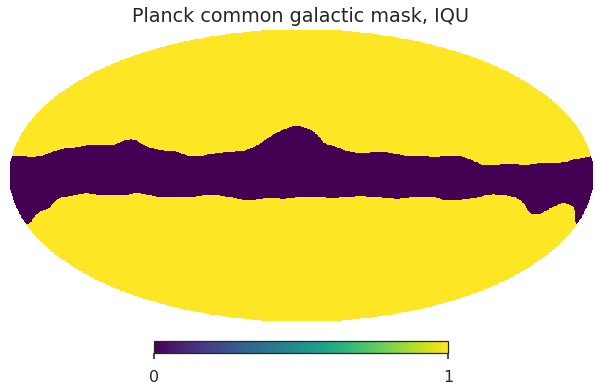

In [46]:
print(f"masking {fsky} of the sky")
hp.mollview(planck_mask, title=f"Planck common galactic mask, {comp}", cmap = 'viridis')

#### Monopole subtraction 


Section 2.2 of [Planck 2018 XII](https://arxiv.org/pdf/1807.06212.pdf) value reported:  0.13 MJy/sr 

we subtract this term only to the I map for   the pixels outside  the Galactic plane mask.

In [47]:
planck2018_monopole = (0.13 * u.MJy / u.sr).to(
    u.uK_RJ, equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

m_planck_varres[0][planck_mask] -= planck2018_monopole


We estimate how many pixels have I< P after we subtract the monopole 

In [48]:
maskmono = m_planck_varres[0] ** 2 < m_planck_varres[1] ** 2 + m_planck_varres[2] ** 2
print(
    f"{maskmono.sum() } pixels out of { maskmono.size} expected to be NaNs in Log Pol Tens maps "
)

5 pixels out of 50331648 expected to be NaNs in Log Pol Tens maps 


In [56]:
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

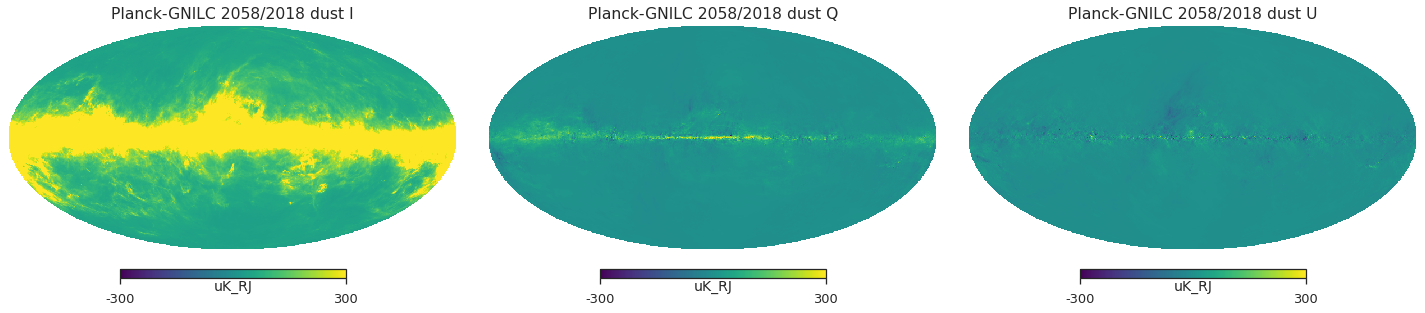

In [55]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        plan
        title="Planck-GNILC 2058/2018 dust " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
        min=-300,
        max=300
    )

## Transform maps to Poltens quantities 

In [5]:
def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [3]:
m_planck_varres = hp.read_map('/global/cscratch1/sd/jianyao/Dust/Dust_IQU_uK_RJ.fits', field = None)

In [6]:
log_pol_tens_varres = map_to_log_pol_tens(m_planck_varres)

<ipython-input-5-ecab0a71aca9>:4: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P ** 2) / 2.0
<ipython-input-5-ecab0a71aca9>:5: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


In [17]:
log_pol_tens_varres.shape

(3, 50331648)

check the transformation back and forth 

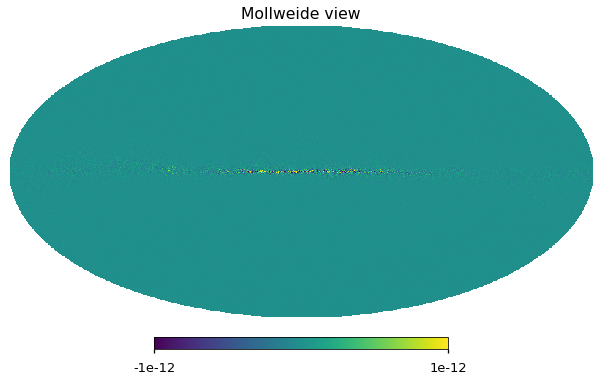

In [26]:
m_back = log_pol_tens_to_map(log_pol_tens_varres)
hp.mollview((m_planck_varres.value - m_back)[1], min=-1e-12, max=1e-12)
del m_back

Checking NaNs  on the Poltens map 

In [24]:
print(
    f"{np.isnan(log_pol_tens_varres[0]).sum()  } pixels out of are NaNs in Log Pol Tens maps "
)

5 pixels out of are NaNs in Log Pol Tens maps 


In [25]:
for i in range(3):
    log_pol_tens_varres[i, np.isnan(log_pol_tens_varres[i])] = np.nanmedian(
        log_pol_tens_varres[i]
    )

Set all the NaNs to the map median value  


In [26]:
assert np.isnan(log_pol_tens_varres).sum() == 0

In [65]:
hp.write_map(
    datadir / "dust_gnilc_logpoltens_varres_nomono.fits",
    log_pol_tens_varres,
    dtype=np.float32,
    overwrite=True,
)

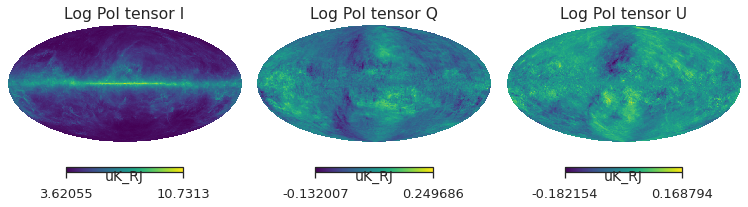

In [66]:
for i_pol, pol in components:
    hp.mollview(
        log_pol_tens_varres[i_pol],
        title="Log Pol tensor " + pol,
        sub=131 + i_pol,
        unit=m_planck_varres.unit,
    )

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

In [20]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins=1):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """
    nside = hp.npix2nside(len(mask))

    binning = nmt.NmtBin(nside=nside, nlb=nlb, lmax=lmax, is_Dell=False)

    cl = {}

    f_0 = nmt.NmtField(mask, [m[0]])

    if len(m) == 3:
        f_2 = nmt.NmtField(mask, m[1:].copy())  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [27]:
print("run anafast on masked sky  ")
ell, cl_norm, cl = run_anafast(log_pol_tens_varres, lmax)

run anafast on masked sky  


In [28]:
ell, cl_norm, cl

(array([   0,    1,    2, ..., 2046, 2047, 2048]),
 array([1.00000000e+00, 3.18309886e-01, 9.54929659e-01, ...,
        6.66566685e+05, 6.67218265e+05, 6.67870164e+05]),
 {'TT': array([2.97308853e+02, 1.97573041e-02, 1.48540100e+00, ...,
         3.43706901e-13, 3.45230531e-13, 3.50475086e-13]),
  'EE': array([0.00000000e+00, 0.00000000e+00, 3.03934324e-03, ...,
         4.72033238e-13, 5.01304994e-13, 4.81137729e-13]),
  'BB': array([0.00000000e+00, 0.00000000e+00, 1.40769293e-04, ...,
         5.13371333e-13, 5.44954319e-13, 4.95865425e-13]),
  'TE': array([ 0.00000000e+00,  0.00000000e+00,  3.82923602e-02, ...,
          3.62746824e-15, -5.46596341e-15, -8.20059073e-16])})

## Fitting the power law from the fullsky power spectra  

We firstly fit a power law spectrum in different multipole ranges.
As we get flatter spectral indices for polarization spectra,  this will yield to  injecting smaller angular scales in TT whose power at given multipole $\ell_*$  is smaller than EE and BB for all $\ell>\ell_*$. 
To avoid this we therefore force EE and BB small scales to follow the fitted TT power law. We also remark  that in this way we get EB ratio closer to ~2.  


In [57]:
for ii, pol in enumerate(spectra_components):
    print(ii, pol)

0 TT
1 EE
2 BB


In [30]:
ell_fit_low = {"TT":100, "EE":30, "BB":30}
ell_fit_high = {"TT":400, "EE":110, "BB":110}

Spectral index from fit for TT=-1.2872818877318104
Spectral index from fit for EE=-0.33416169211989644
Spectral index from fit for BB=-0.4011846388660788
B-to-E ratio w/ fitted power law at l= 110 , 0.8185188150213931
B-to-E ratio w/ TT power law at l= 110 , 0.5973220042017499


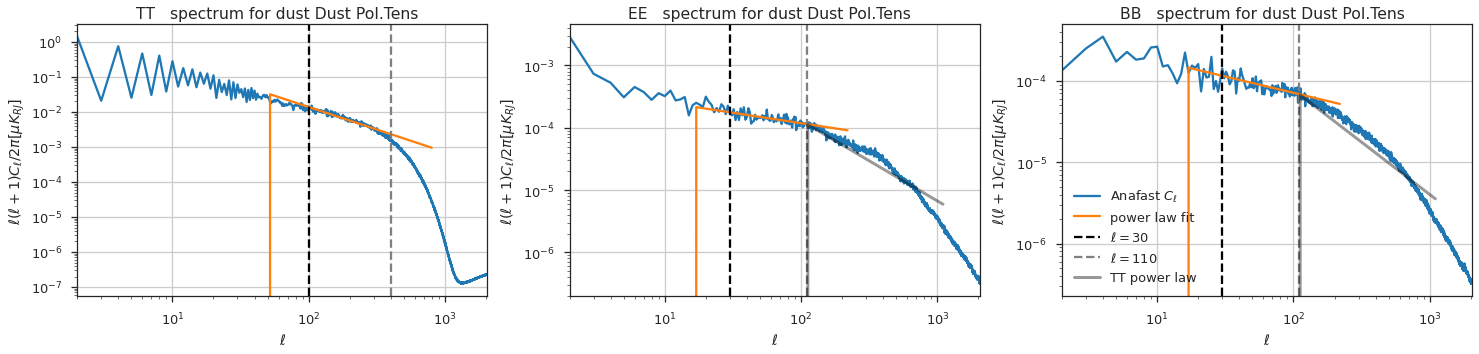

In [72]:

A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in enumerate(spectra_components):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata*(xdata+1)/np.pi/2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))

    plt.loglog(ell, ell*(ell+1)/np.pi/2 * cl[pol], label="Anafast $C_\ell$")
    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]), label="power law fit")
    
    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.grid()
    plt.title(f"{pol}   spectrum for dust Dust Pol.Tens  " )

    plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    print(f"Spectral index from fit for {pol}={gamma_fit[pol]}")
print(f"B-to-E ratio w/ fitted power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 

for ii, pol in enumerate(spectra_components[1:] ):
    #we change the EE and BB power laws 
    A_fit[pol] =A_fit[pol]*  ell_fit_high[pol]**( gamma_fit[pol ] - gamma_fit['TT' ] ) 
    gamma_fit[pol] = gamma_fit['TT'] 
    plt.subplot(132+ii)
    plt.plot(ell[ell_fit_high[pol] :ell_fit_high[pol]*10], 
             model(ell[ell_fit_high[pol]:ell_fit_high[pol]*10], A_fit[pol], gamma_fit[pol]),linewidth=3, alpha=.4, color='k', 
             label="TT power law")
    
print(f"B-to-E ratio w/ TT power law at l= {ell_fit_high['BB']} , { A_fit['BB']/A_fit['EE' ]}" ) 
plt.legend() 


### Define Modulation maps 
as the injected small scales are at different multipoles for intensity and polarization, we consider 2 different modulation maps  

#### Modulation for  polarization : 
- smooth `i` map to 5 deg 
- we saturate all the pixels >4.5 to 1.1 
- reduce the dynamic range to range from .1 to 1.1 with MinMax rescaling  

#### Modulation for  intensity : 
- smooth `i` map to 5 deg 
- for  the pixels >4.5  MinMax rescaling from 1.1 to 2 
- elsewhere MinMax rescaling  from  .1 to 1.1   

In [12]:
log_pol_tens_varres = hp.read_map(datadir / "dust_gnilc_logpoltens_varres_nomono.fits", field = None)

In [13]:
ismooth = hp.smoothing(log_pol_tens_varres[0], fwhm=np.radians(5), lmax=lmax)

In [14]:
b1 = 1.1
b2 = 2
a = 0.1
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

$$a + \frac{(b-a)*(m - min(m))}{max(m) - min(m)}$$

In [16]:
modulate_amp_pol = (ismooth) * 1.0
modulate_amp = (ismooth) * 1.0
val = 4.5
mskmd = ismooth > val
modulate_amp_pol[mskmd] = b1

modulate_amp_pol[~mskmd] = minmax(ismooth[~mskmd], a=a, b=b1)

modulate_amp[mskmd] = minmax(ismooth[mskmd], a=b1, b=b2)

modulate_amp[~mskmd] = minmax(ismooth[~mskmd], a=a, b=b1)

In [39]:
del ismooth, mskmd

In [19]:
hp.write_map(datadir / f"modulate_amp_nside{nside}.fits", modulate_amp, dtype=np.float32, overwrite=True)
hp.write_map(
    datadir / f"modulate_amp_pol_nside{nside}.fits", modulate_amp_pol, dtype=np.float32, overwrite=True
)

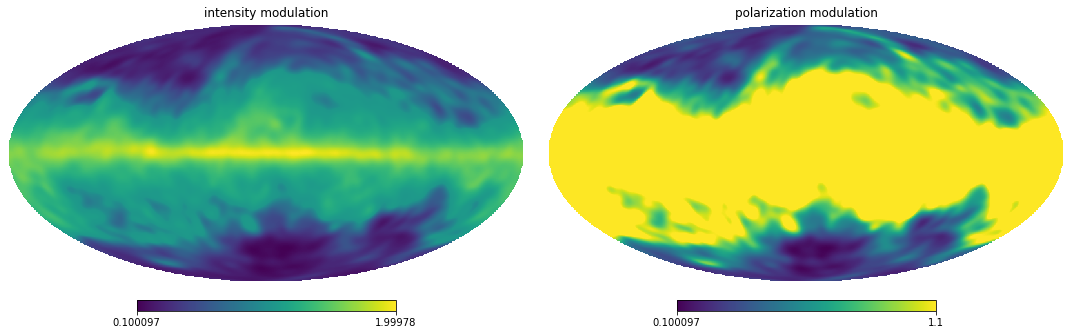

In [18]:
plt.figure(figsize=(15, 5))
hp.mollview(modulate_amp, title="intensity modulation", sub=121)
hp.mollview(modulate_amp_pol, title="polarization modulation", sub=122)

### Making maps with small scales 
1. generate the Cl  from the fit power spectra and with the sigmoid high-pass filter 
2. construct Alm  from the Cl 
3. Filter Alm encoding  small scales with the  sigmoid 
4. Estimate Alm of the fullsky poltens maps encoding large scales  with the sigmoid low-pass filter ,  
5. Estimate maps from the Alm with large and small scales , `ls` and `ss` 
6. modulate small scales with modulation maps , i.e. `ss' =ss * modulation_maps` 
7. define new poltens maps as : `iqu = ls +ss'` 
8.  transform back to real `IQU` maps 

In [32]:
output_nside = 2048 #8192
output_lmax = 2 * output_nside
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[0] = 1

In [ ]:
A_fit

{'TT': 5.200296229854053,
 'EE': 0.048768293952834364,
 'BB': 0.029130375085407098}

In [ ]:
gamma_fit

{'TT': -1.2872818877318104,
 'EE': -1.2872818877318104,
 'BB': -1.2872818877318104}

$$\large{\frac{1.0}{ (1 + exp(\frac{-a * (x - x0 - w / 2)}{ w})}}$$

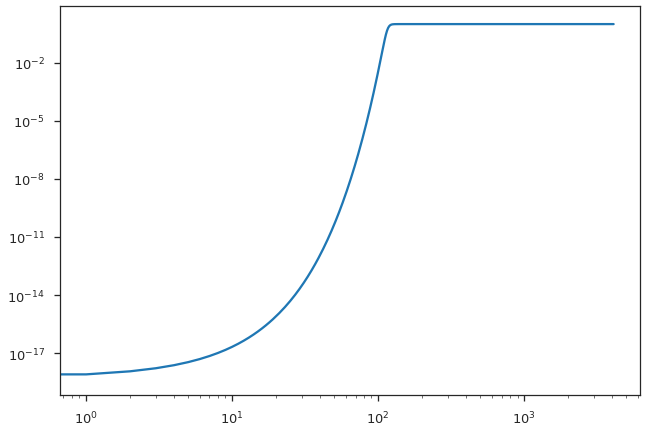

In [95]:
x = output_ell
y = sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
plt.loglog(x, y)

<ipython-input-68-e2b761b15d12>:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


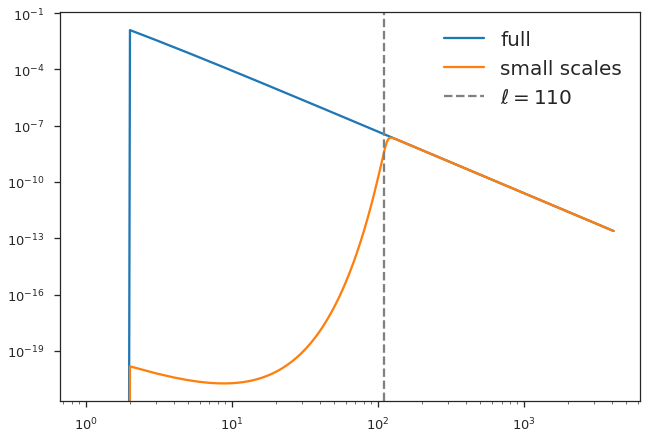

In [93]:
plt.loglog(output_ell, model(output_ell, A_fit[pol], gamma_fit[pol])/ output_cl_norm, label = 'full')
plt.loglog(output_ell, small_scales_input_cl[2], label  = 'small scales')
plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
plt.legend(fontsize = 20)

In [97]:
alm_log_pol_tens_fullsky.shape

(3, 2100225)

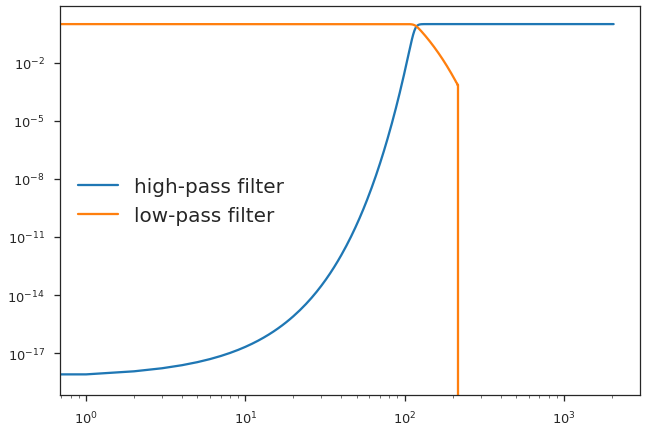

In [107]:
plt.loglog(ell, sig_func, label = 'high-pass filter')
plt.loglog(ell, (1-sig_func)**0.2, label = 'low-pass filter')
plt.legend(fontsize = 20)

In [104]:
output_nside

2048

In [105]:
hp.get_nside(modulate_amp)

2048

In [33]:
# np.random.seed(8192)
# # filter small scales
# small_scales_input_cl = [
#     1
#     * model(output_ell, A_fit[pol], gamma_fit[pol])
#     * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10)
#     / output_cl_norm
#     for pol in spectra_components
# ]
# hp.write_cl(
#     datadir / f"small_scales_logpoltens_cl_lmax{output_lmax}.fits",
#     small_scales_input_cl,
#     dtype=np.complex128,
#     overwrite=True,
# )
alm_log_pol_tens_fullsky = hp.map2alm(
    log_pol_tens_varres, lmax=lmax, use_pixel_weights=True
)

ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)
for ii, pol in enumerate(spectra_components):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)

    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)

# log_ss = hp.synfast(
#     small_scales_input_cl + [np.zeros_like(small_scales_input_cl[0])] * 3,
#     lmax=output_lmax,
#     new=True,
#     nside=output_nside,
# )
# assert np.isnan(log_ss).sum() == 0
# log_ss[0] *= hp.ud_grade(modulate_amp, output_nside)
# log_ss[1:] *= hp.ud_grade(modulate_amp_pol, output_nside)
# assert np.isnan(log_ss).sum() == 0
# hp.write_alm(
#     datadir / f"gnilc_largescale_logpoltens_alm_nside{nside}_lmax{lmax}_complex64.fits",
#     ii_LS_alm,
#     out_dtype=np.complex64,
#     overwrite=True,
# )
log_ls = hp.alm2map(ii_LS_alm, nside=output_nside)
# ii_map_out = log_ss + log_ls

In [35]:
output_with_ls_only = log_pol_tens_to_map(log_ls)

In [36]:
hp.write_map(
    datadir / f"dust_IQU_with_large_scales_only.fits",
    output_with_ls_only,
    dtype=np.float32,
    overwrite=True,
)

In [44]:
del log_ls, ii_LS_alm

In [108]:
output_map = log_pol_tens_to_map(ii_map_out)

hp.write_map(
    datadir / f"dust_gnilc_hybrid_out_nside{output_nside}_float32.fits",
    output_map,
    dtype=np.float32,
    overwrite=True,
)

In [109]:
output_map_alm = hp.map2alm(output_map, lmax=output_lmax)

In [47]:
hp.write_alm(
    datadir / f"dust_gnilc_hybrid_out_alm_nside{output_nside}_lmax{output_lmax}_complex64.fits",
    output_map_alm,
    out_dtype = np.complex64,
    overwrite=True,
)

#### Plot maps 

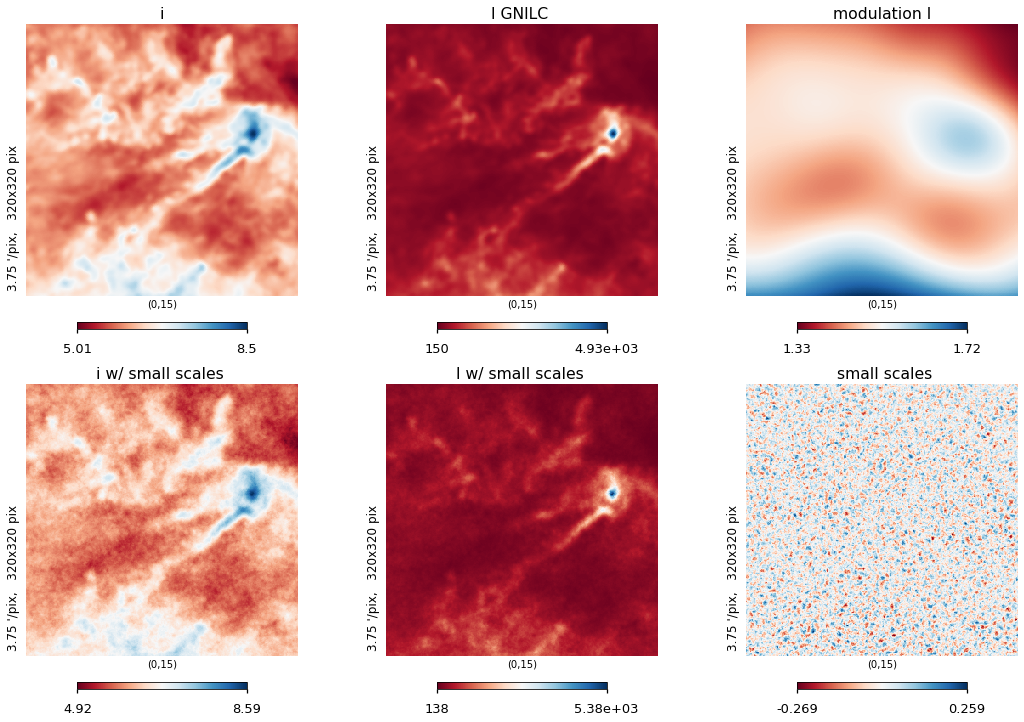

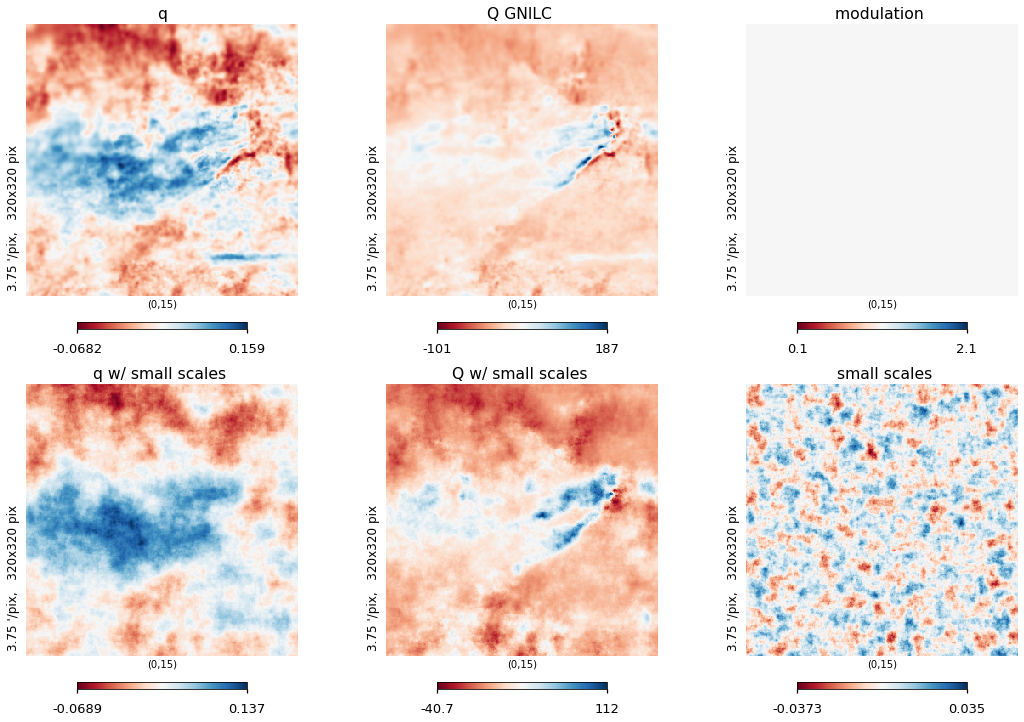

In [48]:
lat=15
plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[0] ,cmap='RdBu',   title='i w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(log_pol_tens_varres [0],cmap='RdBu',  title='i', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview((modulate_amp),cmap='RdBu',  title=' modulation I ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((m_planck_varres [0]),cmap='RdBu',  title=' I GNILC  ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[0],cmap='RdBu',  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[0],cmap='RdBu' ,  title='I w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )

plt.figure(figsize=(15,10))
hp.gnomview(ii_map_out[1],cmap='RdBu' ,  title='q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=234 )
hp.gnomview(log_pol_tens_varres [1],cmap='RdBu',  title='q', rot=[0,lat],reso=3.75,xsize=320, sub=231 )
hp.gnomview((modulate_amp_pol),cmap='RdBu',  title=' modulation  ', rot=[0,lat],reso=3.75,xsize=320,  sub=233, )

hp.gnomview((m_planck_varres [1]),cmap='RdBu',  title=' Q GNILC  ', rot=[0,lat],reso=3.75,xsize=320,  sub=232, )
hp.gnomview((log_ss)[1],cmap='RdBu',  title='  small scales ', rot=[0,lat], reso=3.75,xsize=320, sub=236, )
hp.gnomview(output_map[1] ,cmap='RdBu',  title='Q w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,  sub=235 )



In [49]:
del log_ss, ii_map_out, modulate_amp, modulate_amp_pol

In [50]:
spectra_components += ["TE"]

In [51]:
output_planck_mask = hp.ud_grade(planck_mask, output_nside)

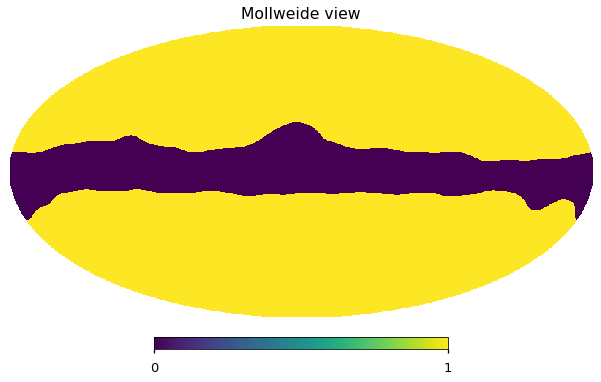

In [52]:
hp.mollview(output_planck_mask)

## Validate outputs estimating NaMaster power spectra on both input and outputs  

we have expanded our validation by means of 3 figures of merit: 

1. TT,EE, BB  power spectra with Namaster 
2. B-to-E ratio  
3. Polarization  fraction 

Moreover, we have considered 4   masks to evaluate the quality of the small scales injected for different $f_{sky} = 0.02,0.2, 0.4,0.8 $. 

Another small difference with previous analysis is that  we estimated the spectra on binned equally-spaced multipoles. We choose $\Delta \ell =35, 25,15,4$   respectively for the 4 masks. 

In [53]:
planck_masks = {"gal080":hp.read_map(datadir/ "HFI_Mask_GalPlane-apo2deg_2048_R2.00_GAL080.fits"),
               "gal040":hp.read_map(datadir/"HFI_Mask_GalPlane-apo2_2048_R2.00_GAL040.fits"),
               "gal020":hp.read_map(datadir/ "HFI_Mask_GalPlane-apo2_2048_R2.00_GAL020.fits"),
               "BK":hp.read_map(datadir/ "BK15_region_Gal_apo.fits")}

planck_masks ={ k:    np.ma.masked_equal(m ,  1 ).mask  for k,m in planck_masks.items() } 

In [55]:
nlb= {'BK':35, 'gal020':25, 'gal040':15,'gal080':4 } 

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


read Namaster spectra  
4 513 513
read Namaster spectra  
4 513 513
read Namaster spectra  
15 138 138
read Namaster spectra  
15 138 138
read Namaster spectra  
25 83 83
read Namaster spectra  
25 83 83
read Namaster spectra  
35 60 60
read Namaster spectra  
35 60 60


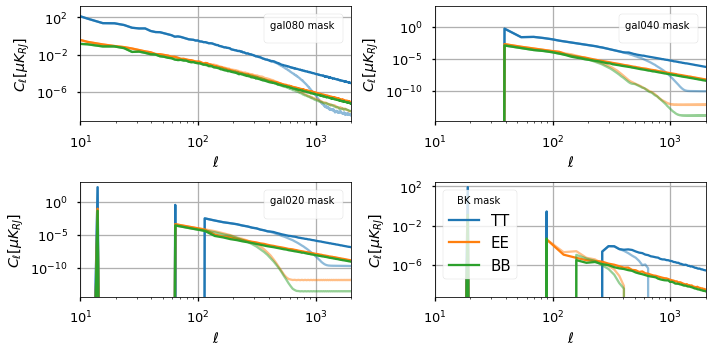

In [58]:
plt.figure(figsize=(10,5))

for jj, k in enumerate(planck_masks.keys())  :
    fspectra = datadir / f"dust_gnilc_hybrid_out_nside2048_float32_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        output_ell, output_cl_norm, cl_out = run_namaster(
            output_map, mask=planck_masks[k], lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)        
    print(nlb[k], output_ell.size, cl_out['TT'].size) 
    #else:
    #    print("run anafast on masked sky  ")
    #    output_ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    
    fspectra = datadir / f"dust_gnilc_varres_no_monopole_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        input_ell, input_cl_norm, cl_in  = run_namaster(
            m_planck_varres, mask=planck_masks[k], lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)        
    #else:
    #    print("run anafast on masked sky  ")
    #    ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    print(nlb[k], input_ell.size, cl_in['TT'].size ) 
    
    plt.subplot(2,2,jj+1 )
    for ii, pol in enumerate(["TT","EE", "BB" ]):
        if jj==3:

            plt.loglog(output_ell,  cl_out [pol],   color='C%d'%ii,   label=pol
                 )
        else: 
            plt.loglog(output_ell,  cl_out [pol],   color='C%d'%ii, )             
        plt.loglog(input_ell,   cl_in [pol], color='C%d'%ii,alpha=.5,)

        plt.grid()
        plt.legend(title=(k +" mask "), fontsize=15)  
        plt.ylabel("$ C_\ell  [\mu K_{RJ}]$")
        plt.xlabel(("$\ell$"))
        plt.xlim(10,2e3) 
plt.tight_layout() 

<ipython-input-59-91064e2bf5a0>:35: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
<ipython-input-59-91064e2bf5a0>:36: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.
<ipython-input-59-91064e2bf5a0>:35: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
<ipython-input-59-91064e2bf5a0>:36: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
No handles with labels found to put in legend.
<ipython-input-59-91064e2bf5a0>:35: RuntimeWarning: invalid value encountered in true_divide
  plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
<ipython-input-59-91064e2bf5a0>:36: RuntimeWarnin

read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  
read Namaster spectra  


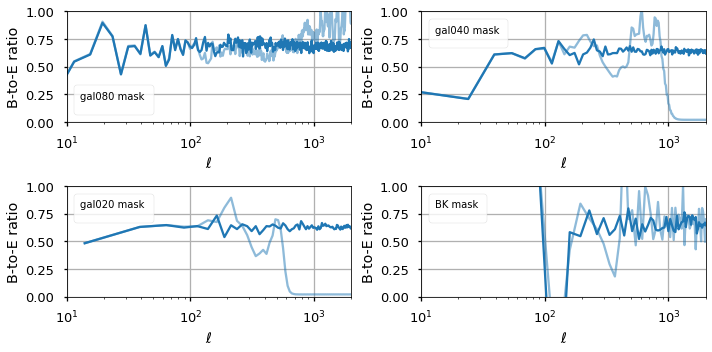

In [59]:
plt.figure(figsize=(10,5))

for jj, k in enumerate(planck_masks.keys())  :
    fspectra = datadir / f"dust_gnilc_hybrid_out_nside2048_float32_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        output_ell = np.load(fspectra)["ell"]
        cl_out = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        output_ell, output_cl_norm, cl_out = run_namaster(
            output_map, mask=planck_masks[k], lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=output_ell, cl_norm=output_cl_norm, **cl_out)        
        
    #else:
    #    print("run anafast on masked sky  ")
    #    output_ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    
    fspectra = datadir / f"dust_gnilc_varres_no_monopole_{k}_spectra.npz"
    if os.path.exists(fspectra):
        print("read Namaster spectra  ")
        input_ell = np.load(fspectra)["ell"]
        cl_in = {kk: np.load(fspectra)[kk] for kk in spectra_components}
    elif namaster_on_nb:
        print("run Namaster  ")
        input_ell, input_cl_norm, cl_in  = run_namaster(
            m_planck_varres, mask=planck_masks[k], lmax=output_lmax, nlbins = nlb[k] 
        )
        np.savez(fspectra, ell=input_ell, cl_norm=input_cl_norm, **cl_in)        
    #else:
    #    print("run anafast on masked sky  ")
    #    ell, cl_norm, cl_out = run_anafast(output_map * planck_mask, lmax)
    plt.subplot(2,2,jj+1 )
    plt.semilogx(output_ell,  cl_out ["BB"]/cl_out["EE"] ,   color='C%d'%0,   )
    plt.semilogx(input_ell,   cl_in ["BB"]/cl_in["EE"], color='C%d'%0,alpha=.5,)
    plt.grid()
    plt.legend(title=(k +" mask "), fontsize=15)  
    plt.ylabel(("B-to-E ratio"))
    plt.xlabel(("$\ell$"))
    plt.ylim(0,1) 
    plt.xlim(10,2e3 ) 
    
plt.tight_layout() 

### Estimate Pol. fraction distribution 

In [60]:
get_polfrac = lambda m: np.sqrt(m[1] ** 2 + m[2] ** 2) / m[0]

In [61]:
Pout = get_polfrac(output_map)
Pin = get_polfrac(m_planck_varres.value)

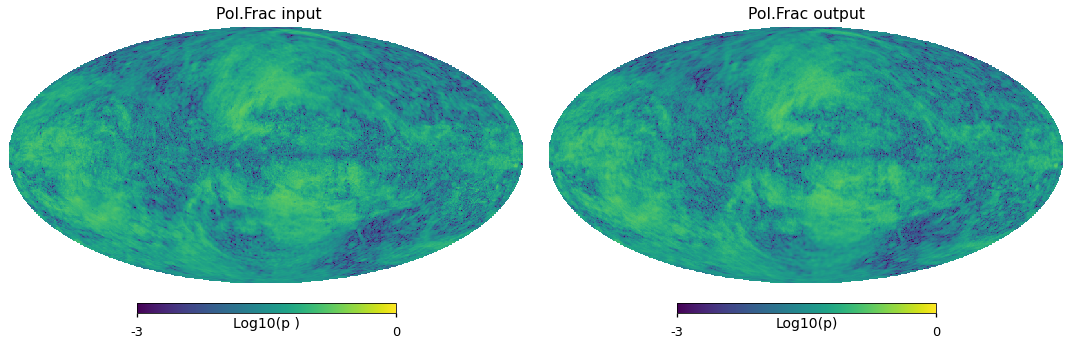

In [62]:
plt.figure(figsize=(15, 5))
hp.mollview(
    np.log10(Pin), title=" Pol.Frac input", sub=121, min=-3, max=0, unit="Log10(p )"
)
hp.mollview(
    np.log10(Pout), title="Pol.Frac output", sub=122, min=-3, max=0, unit="Log10(p)"
)

In [63]:
logpin = np.log10(Pin)
logpout = np.log10(Pout)

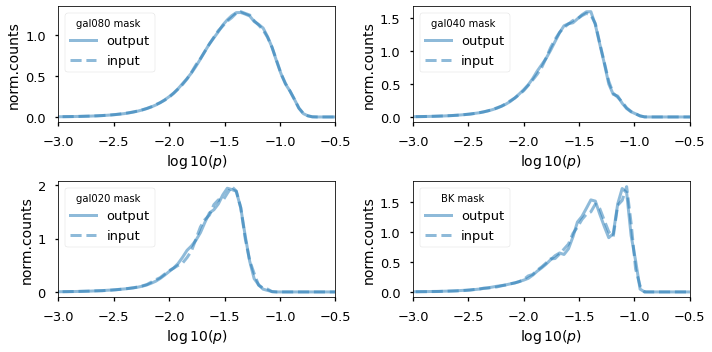

In [64]:
plt.figure(figsize=(10,5))

for jj,pm  in enumerate(planck_masks.items())  :
    k =pm[0]
    msk =pm[1] 
    
    plt.subplot(2,2,jj+1 )
    

    h,edg= np.histogram(
        logpout[msk] ,
        bins=np.linspace(-4, 0, 100), density=True)
    xb = np.array([(edg[i] +edg[i+1])/2 for i in range(edg.size-1)])
    
    plt.plot( xb,h,
        lw=3,
       color='C0', alpha=.5,label='output'

    )
    h, edg= np.histogram(
        logpin[msk] ,
        density=True ,
        bins=np.linspace(-4, 0, 100))  
    xb = np.array([(edg[i] +edg[i+1])/2 for i in range(edg.size-1)])
    
    plt.plot(xb,h , 
        lw=3,alpha=.5 ,color='C0' ,linestyle='--',label='input'
    )
    plt.ylabel("norm.counts", fontsize=14)
    plt.xlabel(r"$\log10( p )$", fontsize=14)
    plt.legend(title=(k +" mask "), fontsize=13, loc='best' )  
    plt.xlim(-3,-0.5)         
plt.tight_layout() 


## Injecting small scales to Spectral parameters 

In [65]:
logm =hp.read_map( datadir/"dust_gnilc_logpoltens_varres_nomono.fits" )
ismooth= hp.smoothing (logm , fwhm=np.radians(5),lmax=lmax )


In [66]:
b1=1.1
b2=1.5 
a=.1
minmax= lambda m,a,b: a + (b-a) * (m - m .min()  )/(m .max() -m .min () )

modulate_amp= (ismooth )*1. 
val=4.5
mskmd= ismooth >val 

modulate_amp[mskmd]=minmax(ismooth[mskmd] , a=b1, b=b2)

modulate_amp[~mskmd]=minmax(ismooth[~mskmd] , a=a, b=b1)  



In [67]:
tdfile  = datadir /"COM_CompMap_Dust-GNILC-Model-Temperature_2048_R2.00.fits" 
if not tdfile.exists():
    !wget -O $tdfile  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-Model-Temperature_2048_R2.00.fits
bdfile  = datadir /"COM_CompMap_Dust-GNILC-Model-Spectral-Index_2048_R2.00.fits"

if not bdfile.exists():
    !wget -O $bdfile http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-Model-Spectral-Index_2048_R2.00.fits


In [68]:
td= hp.read_map(tdfile) 
bd= hp.read_map(bdfile) 


In [69]:
cltd = hp.anafast(td, lmax=lmax) 
clbd = hp.anafast(bd, lmax=lmax) 

cl={'bd': clbd, 'td':cltd } 
dust_params = list(cl.keys() ) 
ell = np.arange(lmax+1  ) 

In [ ]:
ell_fit_low = {"bd":200, "td":100 }
ell_fit_high = {"bd":400, "td":400 } 

A_fit, gamma_fit, A_fit_std, gamma_fit_std = {},{},{},{}
plt.figure(figsize=(25,5))

for ii, pol in  enumerate(dust_params ):
    plt.subplot(131+ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata =   cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.loglog(ell,  cl[pol], label=" Anafast $C_\ell$")

    plt.plot(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], 
             model(ell[ell_fit_low[pol]//2:ell_fit_high[pol]*2], A_fit[pol], gamma_fit[pol]), label="model fit")
    
    plt.axvline(ell_fit_low[pol], linestyle="--", color="black", label="$ \ell={} $".format(ell_fit_low[pol]))
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray", label="$ \ell={} $".format(ell_fit_high[pol]))
    plt.legend()
    plt.grid()
    plt.title(f"{pol}   spectrum for dust   "+r"$\gamma_{fit}=$"+f"{gamma_fit[pol]:.2f}")

    plt.ylabel("$ C_\ell $")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)


In [70]:
datadir

PosixPath('/global/cscratch1/sd/giuspugl/workstation/FG_extension/extending_gnilc_dust')


- We inject smaller angular scales to the maps  by extrapolating the power law fitted from the GNILC spectral parameter maps 

- Smaller angular scales are modulated similarly as the intensity map in pol tens formalism. 

- the multipoles where the fit is performed are different given the observed spectra . In any case we don't fit beyond $\ell=400$, which is consistent with the TT analysis above 
- given the fact that we inject smaller angular scales with a steeper spectral index  than TT
$$\gamma_{\beta} = -1.96, \gamma_{Td} = -2.47, \gamma_{TT}= -1.29$$

we don't expect to injecti _small scale noise_ when rescaling at frequencies orders of magnitude lower or larger than  the reference one ( 353 GHz). 


In [ ]:
np.random.seed(777)
#filter small scales 
small_scales_input_cl = [
    1 \
    * model(ell, A_fit[pol], gamma_fit[pol]) \
    *  (sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol]/10)  ) 
    for pol in dust_params 
]
bd_ss_alm =hp.synalm(small_scales_input_cl[0]  ,lmax=lmax )
td_ss_alm =hp.synalm(small_scales_input_cl[1]  ,lmax=lmax  )
alm_bd  = hp.map2alm(  bd    , lmax=lmax, use_pixel_weights=True)
alm_td  = hp.map2alm(  td    , lmax=lmax, use_pixel_weights=True)

bd_LS_alm=np.empty_like(alm_bd)
td_LS_alm=np.empty_like(alm_bd)
sig_func =  sigmoid(ell, x0= ell_fit_high['bd'], width= ell_fit_high['bd' ]/10)
bd_LS_alm= hp.almxfl(alm_bd ,  np.sqrt(1.-sig_func) ) 
td_LS_alm = hp.almxfl(alm_td ,  np.sqrt(1.-sig_func)  ) 

bd_ss =hp.alm2map( bd_ss_alm , nside=nside ) 
td_ss =hp.alm2map( td_ss_alm , nside=nside ) 

bd_ss *=modulate_amp 
td_ss *=modulate_amp

bd_ls =hp.alm2map(bd_LS_alm, nside=nside ) 
td_ls =hp.alm2map(td_LS_alm, nside=nside ) 
bd_out = bd_ss + bd_ls
td_out = td_ss + td_ls


In [ ]:
cl_out={ 'bd':  hp.anafast(bd_out, lmax=lmax) , 
'td':  hp.anafast(td_out, lmax=lmax) } 


In [ ]:
for ii, pol in  enumerate(dust_params):
    plt.loglog(ell,  cl[pol],  alpha=.5, color='C%d'%ii )
    plt.loglog(ell,  cl_out[pol], label=f" {pol}   ", color='C%d'%ii )
        
    plt.legend()
    plt.grid(True)
    plt.plot(ell[100:][2:] , 
             model(ell[100:], A_fit[pol], gamma_fit[pol])[2:]  , '--' ,color='red' )
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray" )
    plt.axvline(100 , linestyle="--", color="gray" )
    
    plt.ylabel("$ C_\ell $")
    plt.xlabel(("$\ell$"))
    #plt.xlim(350, 500 )    
    plt.xlim(2, lmax  )

In [ ]:
lat=35
cm= plt.cm.RdBu 
plt.figure(figsize=(15,8))
hp.gnomview(bd_out ,  title='Bd  w/ small scales ', rot=[0,lat],reso=3.75,cmap=cm, xsize=320,  sub=234, min=1.2, max=1.9 )
hp.gnomview(bd_ss,  title='small scales ', rot=[0,lat],reso=3.75,xsize=320,cmap=cm, sub=232 )
hp.gnomview((m_planck_varres [0] ),  title=' GNILC I MAP  ', rot=[0,lat],reso=3.75,cmap=cm,xsize=320,  sub=233, )

hp.gnomview((bd),  title=' Bd  GNILC  ', rot=[0,lat],reso=3.75,xsize=320,cmap=cm,  sub=235, min=1.2, max=1.9, )
hp.gnomview( bd_ls ,  title='  Bd large scales ', rot=[0,lat], reso=3.75,cmap=cm,xsize=320, sub=231, min=1.2, max=1.9, )

plt.figure(figsize=(15,8))
hp.gnomview(td_out ,  title='Td  w/ small scales ', rot=[0,lat],reso=3.75,xsize=320,cmap=cm,  sub=234, min=15,max=25  )
hp.gnomview(td_ss,  title='small scales ', rot=[0,lat],reso=3.75,xsize=320, sub=232,cmap=cm )
hp.gnomview((modulate_amp),  title=' modulation  ', rot=[0,lat],reso=3.75,xsize=320,cmap=cm,  sub=233, )

hp.gnomview((td),  title=' Td  GNILC  ', rot=[0,lat],reso=3.75,xsize=320,  sub=235,cmap=cm, min=15,max=25 )
hp.gnomview( td_ls ,  title='  Td large scales ', rot=[0,lat], reso=3.75,xsize=320,cmap=cm, sub=231, min=15,max=25 )



In [ ]:
del ismooth ,modulate_amp, bd_ss, bd_ls, td_ss, td_ls 